<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/ImageSeg%26DepthPred_Tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e78dc564-9f15-2937-5942-cc9681e335c6)


In [3]:
from zipfile import ZipFile

output_dir = "/content/tiny_data"
# Get information about how much you're decompressing
zf = ZipFile('/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/tiny_data.zip')
uncompress_size = sum((file.file_size for file in zf.infolist()))
print('uncompressed_size',uncompress_size/1e6)

# Loop through all files attempting to decompress each individually
extracted_size = 0
for idx, file in enumerate(zf.infolist()):
    extracted_size += file.file_size
    if(idx%10000==0):
      print ("%s %%" % (extracted_size * 100/uncompress_size))
    try:
      zf.extract(file, output_dir)
    except:
      continue

zf.close()

uncompressed_size 371.686523
0.004410437017647799 %
33.68035326909069 %
67.34241074433575 %
76.9080742268398 %
85.65884698488247 %
92.74335297866047 %
99.77619123951933 %


In [2]:
import sys

%rm -rf /content/eva
!git clone https://github.com/raguram/eva.git

sys.path.append("/content/eva/cnn-lib/src/cnnlib")
sys.path.append("/content/eva/cnn-lib/src/")
print("Added required libraries to system path")

Cloning into 'eva'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 719 (delta 12), reused 21 (delta 8), pack-reused 691
Receiving objects: 100% (719/719), 32.40 MiB | 37.71 MiB/s, done.
Resolving deltas: 100% (326/326), done.
Added required libraries to system path


In [0]:
from DataUtility import Alb
from albumentations import *
from albumentations.pytorch import ToTensor
from cnnlib import Utility
from cnnlib.models.S11Resnet import S11Resnet
from torch.nn import functional as F
from cnnlib.DataUtility import Alb
import numpy as np
from cnnlib import DataUtility
import torch.optim as optim
from cnnlib.datasets.DepthDataset import DepthDataset
import torch
from cnnlib.models.ResUNet import ResUNet_Lite as ResUNet
from cnnlib.image_seg.ModelBuilder import *
import torch
from torchsummary import summary
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm_notebook as tqdm
from DataUtility import shape

In [0]:
model = ResUNet(6, 1).to(Utility.getDevice())
# summary(model, (6, 224, 224))

In [5]:
transforms = Alb(Compose([
    ToTensor()
]))

dataset = DepthDataset("/content/tiny_data", transforms, transforms, transforms, transforms)

train_dataset = torch.utils.data.Subset(dataset, range(0, 15000))
test_dataset = torch.utils.data.Subset(dataset, range(15000, 20000))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=2)

data = iter(train_loader).next()
print(f"Shape of a train data batch: {data['fg_bg'].shape}")

data = iter(test_loader).next()
print(f"Shape of a test data batch: {data['fg_bg'].shape}")

Shape of a train data batch: torch.Size([64, 3, 224, 224])
Shape of a test data batch: torch.Size([64, 3, 224, 224])


In [7]:
torch.cuda.empty_cache()

from cnnlib.DataUtility import Data
from cnnlib.image_seg.ModelBuilder import ModelBuilder
from image_seg.PredictionPersister import ZipPredictionPersister

loss_fn = BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
persister = ZipPredictionPersister(zip_file_name="test_tiny_output.zip", out_folder_pattern="epoch-{}/fg_bg_mask")

builder = ModelBuilder(model=model, data=Data(train_loader=train_loader, test_loader=test_loader), loss_fn=loss_fn,
                       optimizer=optimizer, test_pred_persister=persister,
                       checkpoint=5, model_path="model.pt")

result = builder.fit(20)
print(result.train_losses, result.test_losses)



Epoch: 1



Train Loss: 0.002885141667723656, Learning Rate: 0.01
Predicting on test set.



Test Loss: 0.0029988721460103987
Saved the model to path:model.pt


Epoch: 2



Train Loss: 0.002535155619184176, Learning Rate: 0.01


Epoch: 3



Train Loss: 0.0022692337820927303, Learning Rate: 0.01


Epoch: 4



Train Loss: 0.002090016907453537, Learning Rate: 0.01


Epoch: 5



Train Loss: 0.001951920575896899, Learning Rate: 0.01


Epoch: 6



Train Loss: 0.0018381971031427382, Learning Rate: 0.01
Predicting on test set.



Test Loss: 0.002122621437907219
Saved the model to path:model.pt


Epoch: 7



Train Loss: 0.001756124118467172, Learning Rate: 0.01


Epoch: 8



Train Loss: 0.0016699014698465665, Learning Rate: 0.01


Epoch: 9



Train Loss: 0.0016030197436610859, Learning Rate: 0.01


Epoch: 10



Train Loss: 0.0015520684858163199, Learning Rate: 0.01


Epoch: 11



Train Loss: 0.001494827892879645, Learning Rate: 0.01
Predicting on test set.



Test Loss: 0.0018968800589442252
Saved the model to path:model.pt


Epoch: 12



Train Loss: 0.0014481612374385197, Learning Rate: 0.01


Epoch: 13



Train Loss: 0.0014133539458115896, Learning Rate: 0.01


Epoch: 14



Train Loss: 0.001376859287917614, Learning Rate: 0.01


Epoch: 15



Train Loss: 0.0013432254721721013, Learning Rate: 0.01


Epoch: 16



Train Loss: 0.0013086606686313947, Learning Rate: 0.01
Predicting on test set.



Test Loss: 0.001814551055431366
Saved the model to path:model.pt


Epoch: 17



Train Loss: 0.0012839427893360457, Learning Rate: 0.01


Epoch: 18



Train Loss: 0.0012550368189811706, Learning Rate: 0.01


Epoch: 19



Train Loss: 0.0012279582306742667, Learning Rate: 0.01


Epoch: 20



Train Loss: 0.0012091482291618984, Learning Rate: 0.01
Predicting on test set.



Test Loss: 0.001901478424668312
Saved the model to path:model.pt
[0.002885141667723656, 0.002535155619184176, 0.0022692337820927303, 0.002090016907453537, 0.001951920575896899, 0.0018381971031427382, 0.001756124118467172, 0.0016699014698465665, 0.0016030197436610859, 0.0015520684858163199, 0.001494827892879645, 0.0014481612374385197, 0.0014133539458115896, 0.001376859287917614, 0.0013432254721721013, 0.0013086606686313947, 0.0012839427893360457, 0.0012550368189811706, 0.0012279582306742667, 0.0012091482291618984] [0.0029988721460103987, 0.002122621437907219, 0.0018968800589442252, 0.001814551055431366, 0.001901478424668312]


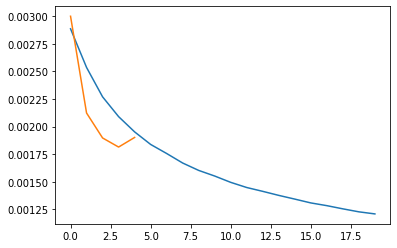

In [14]:
from matplotlib import pyplot as plt
plt.plot(result.train_losses, label="Train")
plt.plot(result.test_losses, label="Test")
plt.show()

In [10]:
!rm -rf /content/test_tiny_output
!unzip /content/test_tiny_output.zip -d /content/test_tiny_output

Streaming output truncated to the last 5000 lines.
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_50_158_211167.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_21_115_89673.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_89_57_371383.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_64_120_268656.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_47_114_197813.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_55_43_229666.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_103_185_432189.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_80_72_334258.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_101_57_421304.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_86_102_359806.JPEG  
 extracting: /content/test_tiny_output/epoch-19/fg_bg_mask/Image_42_66_176058.JPEG  
 extrac

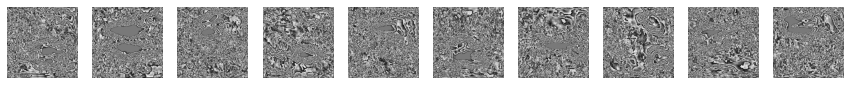

In [12]:
import ImageUtils
from os import listdir
from os.path import join
from PIL import Image

files = listdir("/content/test_tiny_output/epoch-19/fg_bg_mask")

ImageUtils.show_images([Image.open(join("/content/test_tiny_output/epoch-19/fg_bg_mask", f)) for f in files[:10]])

In [0]:
!cp test_tiny_output.zip /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/